In [151]:
import numpy as np
import pandas as pd

import lightgbm as lgb
from lightgbm import LGBMClassifier

import scipy
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import chi2_contingency

import time
import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

#Open solution
import sys
from tqdm import tqdm_notebook as tqdm
from functools import partial
from sklearn.externals import joblib
from sklearn.linear_model import LinearRegression

sys.path.append('../')

In [152]:
#Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [153]:
import os
print(os.listdir('../Documents/JK/AV_WNS'))
dir = '../Documents/JK/AV_WNS/'
del os

['.DS_Store', 'RF_oof_preds.csv', 'submission_LGB_Clf.csv', 'Test', 'lgb_oof_preds.csv', 'test.csv', 'submission_RF_Clf.csv', 'submission_LGB_Clf_NoStrat.csv', 'submission_log_Clf.csv', 'AV_vote.csv', 'Oof_files', 'train.csv', 'submission_LGB_Clf.xlsx', 'submission_LGB_Clf_basic.csv', 'log_oof_preds.csv', 'sample_submission.csv']


In [154]:
#Function to creating dummy variables for Nominal fields for a set of columns
def create_dummy_set(df_col,df):
    for i in df_col:
        dummies = pd.get_dummies(df[i]).rename(columns=lambda x: i+'_'+ str(x))
        #Adding to input variables
        df = pd.concat([df, dummies], axis=1)
        #Dropping column without having to reassign
        df.drop([i], inplace=True, axis=1)
        print (df.shape)
    return df

In [155]:
#To handle binary variables
lb=LabelEncoder()
def LabelEncoding_Cat(df):
    df=df.copy()
    Cat_Var=df.select_dtypes(include=['object']).columns.tolist()
    for col in Cat_Var:
        df[col]=lb.fit_transform(df[col].astype('str'))
    return df

In [156]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype.name == 'category']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [157]:
#Function to check % of missing values
def missing_values_table(df): 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    return mis_val_table_ren_columns

In [159]:
#Define a generic function using Pandas replace function#Define 
def coding(col, codeDict):
    colCoded = pd.DataFrame(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

In [160]:
#Function to change the dataframe memory/size to optimal value
def reduce_mem_usage(data, verbose = True):
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data

In [161]:
print("Loading data....\n")
df_train = pd.read_csv(dir+'train.csv')
df_train = reduce_mem_usage(df_train, verbose=True)

df_test = pd.read_csv(dir+'test.csv')
df_test = reduce_mem_usage(df_test, verbose=True)
print (df_train.shape, df_test.shape)

Loading data....

Memory usage of dataframe: 5.85 MB
Memory usage after optimization: 2.77 MB
Decreased by 52.7%
Memory usage of dataframe: 2.33 MB
Memory usage after optimization: 1.16 MB
Decreased by 50.0%
(54808, 14) (23490, 13)


In [162]:
df = df_train.append(df_test, sort=False)

In [167]:
#Change categories to numeric values
df["education"] = coding(df["education"], {"Master's & above":3,"Bachelor's":2,"Below Secondary":1})
df.rename(columns = {'education' : 'education_coded'}, inplace=True)

In [168]:
df.education_coded.unique()

array([ 3.,  2., nan,  1.])

In [169]:
missing_values_table(df)

,Missing Values,% of Total Values
employee_id,0,0.000000
department,0,0.000000
region,0,0.000000
education_coded,3443,4.397303
gender,0,0.000000
recruitment_channel,0,0.000000
no_of_trainings,0,0.000000
age,0,0.000000
previous_year_rating,5936,7.581292
length_of_service,0,0.000000


In [178]:
df.update(df['previous_year_rating'].fillna(-1))
df.update(df['education_coded'].fillna(-1))

In [170]:
#Filter columns into numerical & categorical
df_num = df.select_dtypes(include=[np.number]) #Numbers which are categories must be verified
df_cat = df.select_dtypes(exclude=[np.number])
print (df_num.shape, df_cat.shape)

(78298, 10) (78298, 4)


In [171]:
#Find Count of distinct values in categorical fields
count = df_cat.apply(pd.Series.nunique)
dstnct_cnt_col = pd.DataFrame(count, columns=['count'])
dstnct_cnt_col

,count
department,9
region,34
gender,2
recruitment_channel,3


In [172]:
#Binary Variables(1 or 2)
df_binary_col = dstnct_cnt_col.loc[dstnct_cnt_col['count'] <=2]
df_binary_col = df_binary_col.index.values.tolist()
df_binary = df_cat[df_binary_col]
#Nominal Variables(2+)
df_nominal_col = dstnct_cnt_col.loc[dstnct_cnt_col['count'] >2]
df_nominal_col = df_nominal_col.index.values.tolist()
df_nominal = df_cat[df_nominal_col]

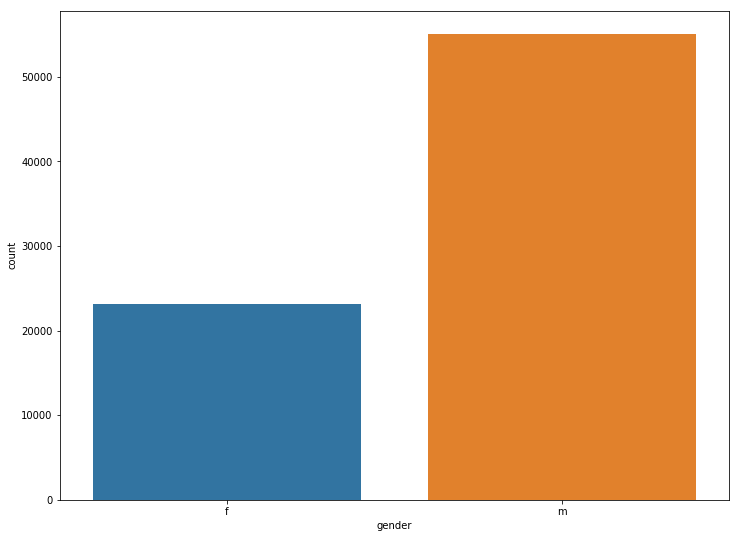

In [173]:
#EDA plots - 1 
#Univariate analysis - Checking distribution of binary variables
for i in df_binary_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df_cat);
    plt.show()

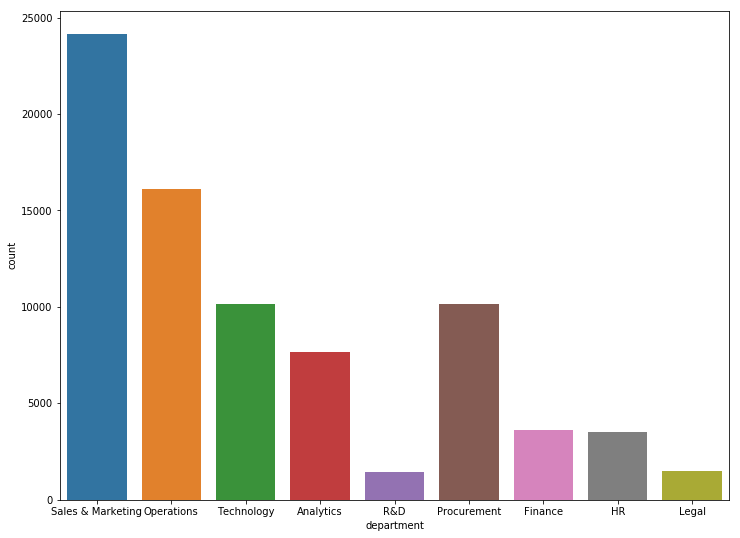

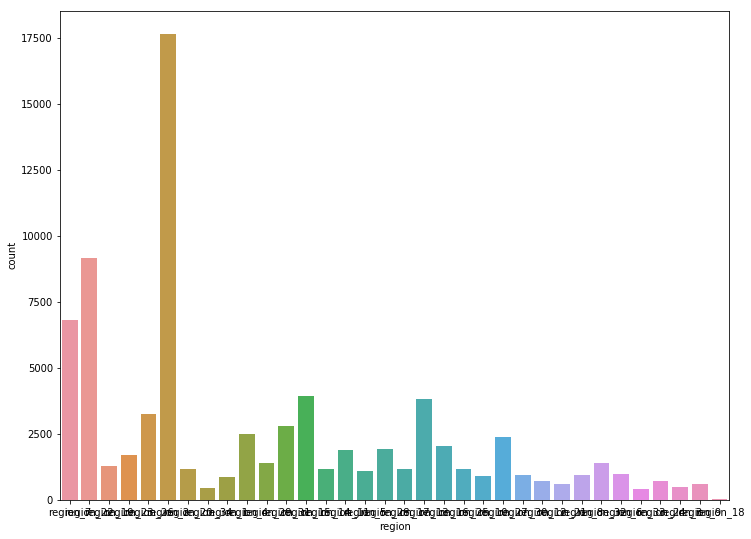

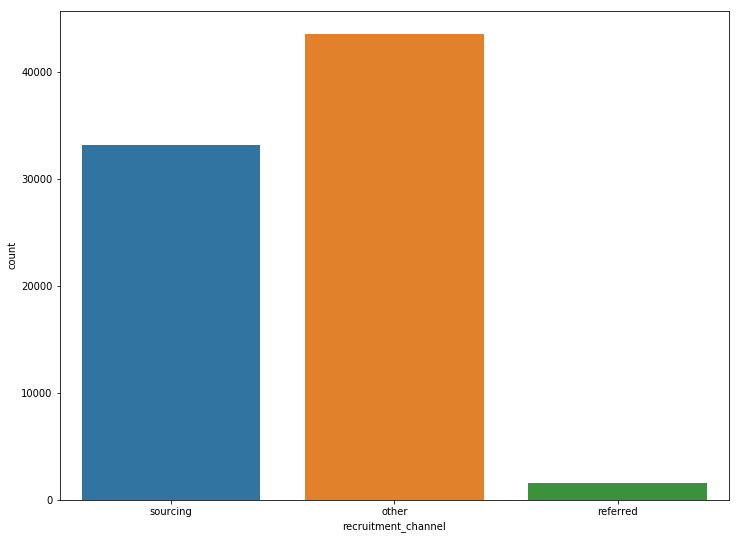

In [174]:
#EDA plots - 2 
#Univariate analysis - Checking distribution of nominal variables
for i in df_nominal_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df_cat);
    plt.show()

In [238]:
# from scipy.stats import boxcox
# from numpy import exp, sqrt
# # power transform
# df['avg_training_score_tfm'] = sqrt(df['avg_training_score'])
# df['avg_training_score_tfm'] = boxcox(df['avg_training_score_tfm'], -1)
# #EDA plots - 3
# #Univariate analysis - Checking distribution of numerical variables using histogram
# df.hist(column='avg_training_score_tfm', bins = 100)
# plt.show()

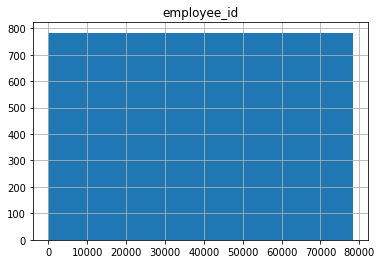

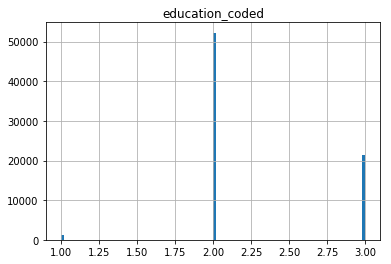

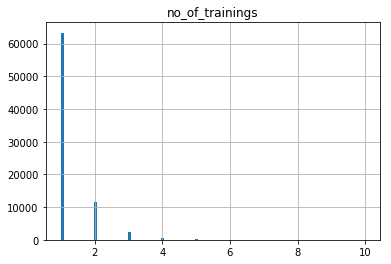

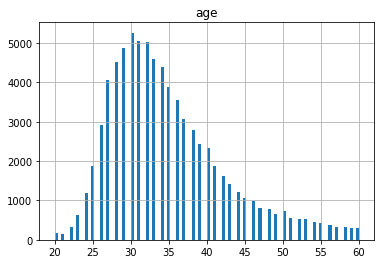

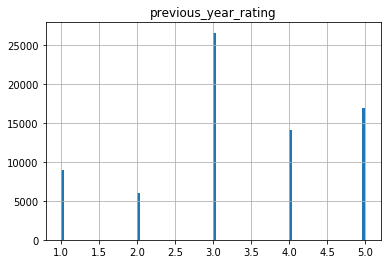

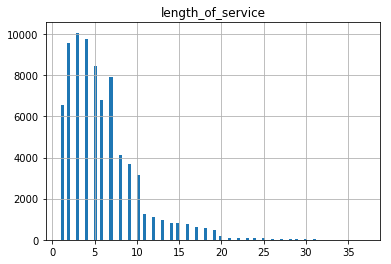

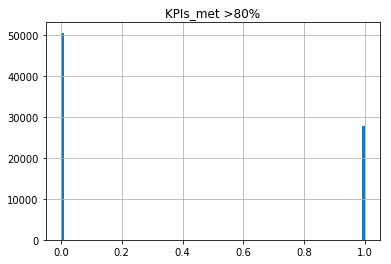

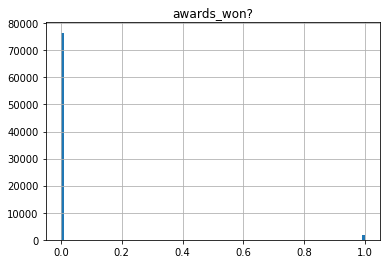

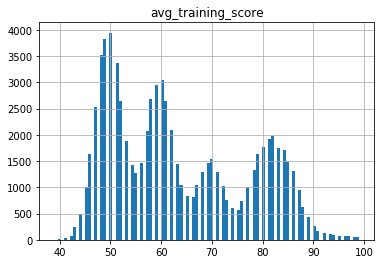

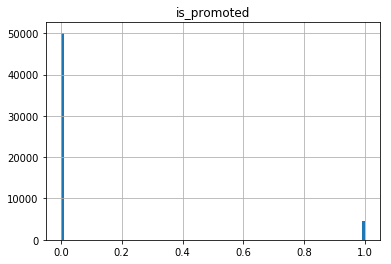

In [176]:
#EDA plots - 3
#Univariate analysis - Checking distribution of numerical variables using histogram
for i in df_num.columns.tolist():
    df_num.hist(column=i, bins = 100)
    plt.show()

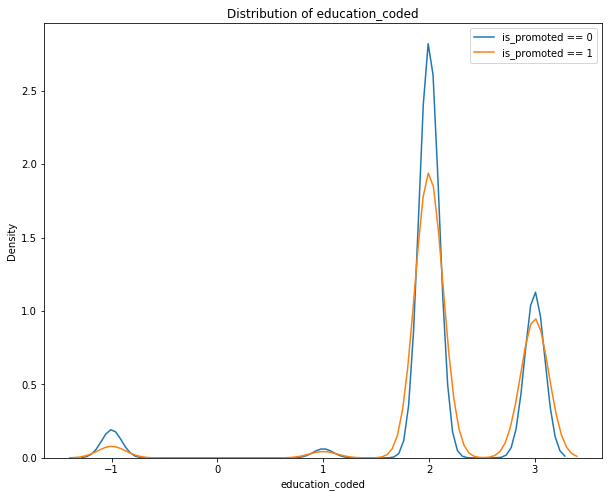

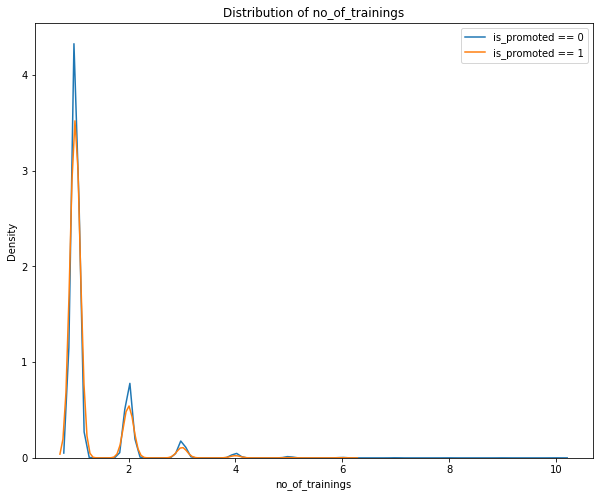

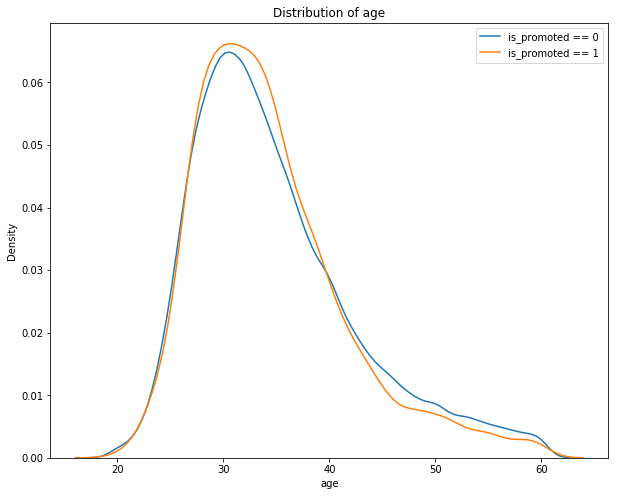

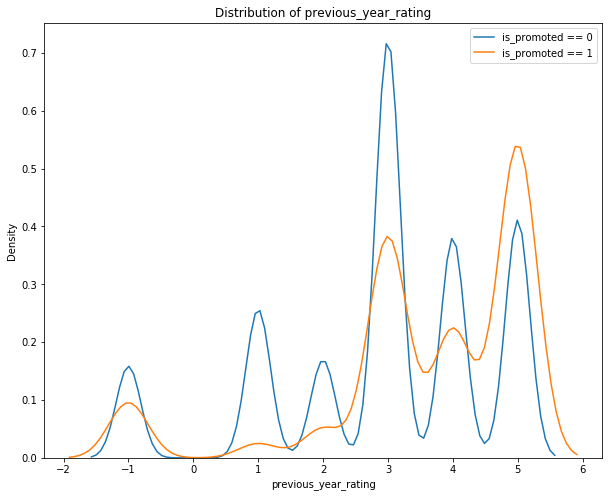

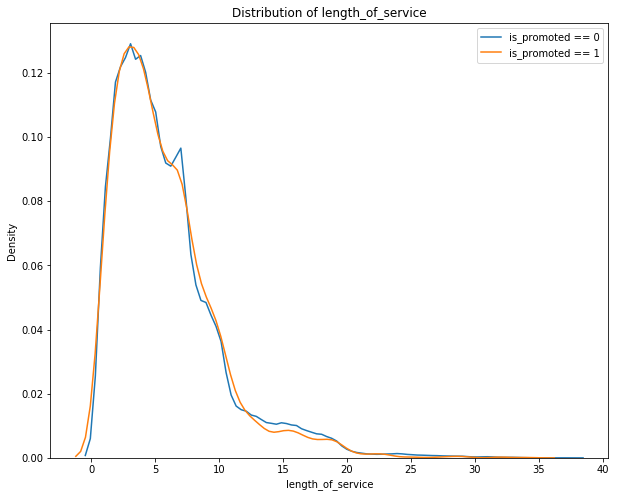

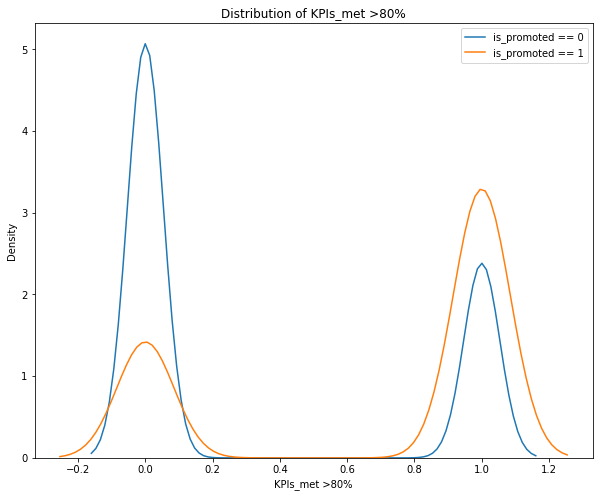

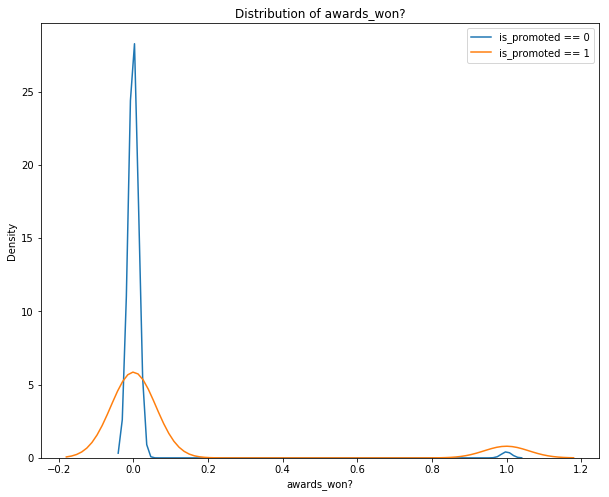

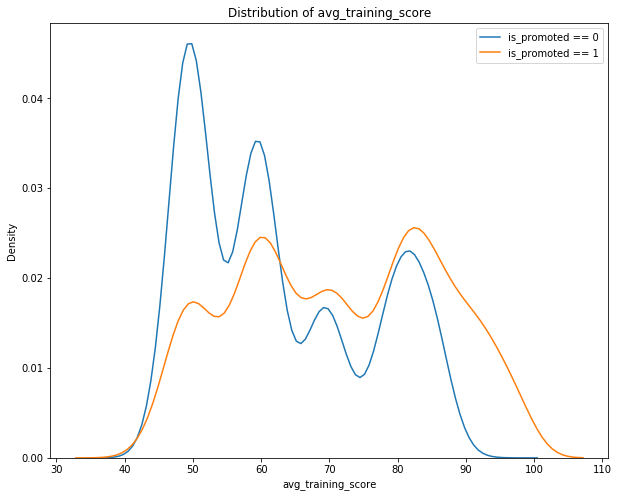

In [181]:
for i in [f for f in df_num.columns.tolist() if f != 'is_promoted' if f != 'employee_id']:
    
    plt.figure(figsize = (10, 8))

    # KDE plot of loans that were repaid on time
    sns.kdeplot(df.loc[df['is_promoted'] == 0, i], label = 'is_promoted == 0')

    # KDE plot of loans which were not repaid on time
    sns.kdeplot(df.loc[df['is_promoted'] == 1, i], label = 'is_promoted == 1')

    # Labeling of plot
    plt.xlabel(i); plt.ylabel('Density'); plt.title('Distribution of '+i);

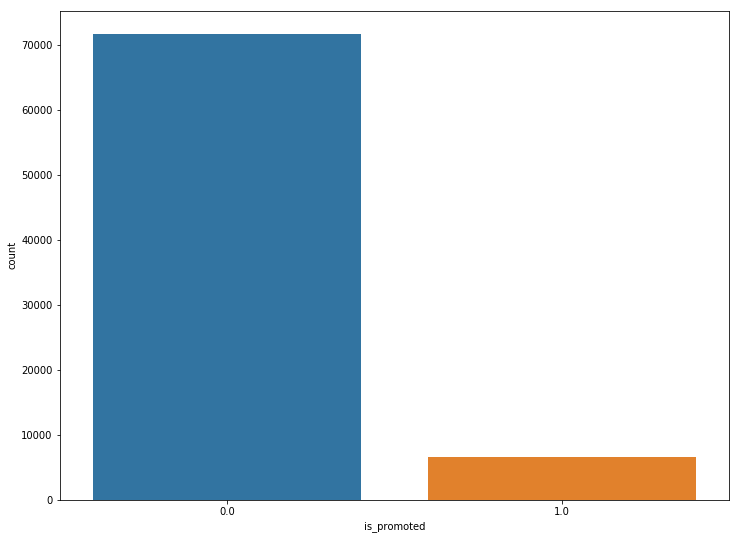

In [182]:
#EDA plots - 4
#Target distribution
df_Y_col = df['is_promoted'].index.values.tolist()
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
sns.countplot(x = df_Y_col, data=df['is_promoted']);
plt.show()

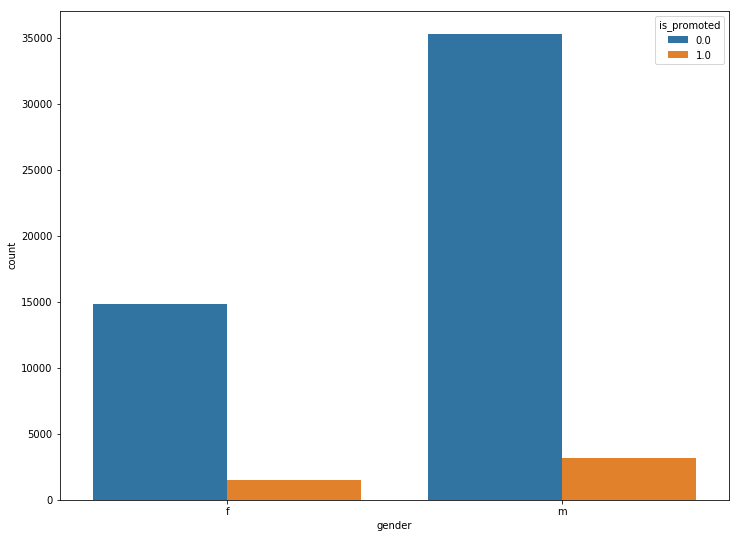

In [183]:
#EDA - 5 Bi-variate analysis on binary variables
for i in df_binary_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df, hue='is_promoted')
    plt.show()

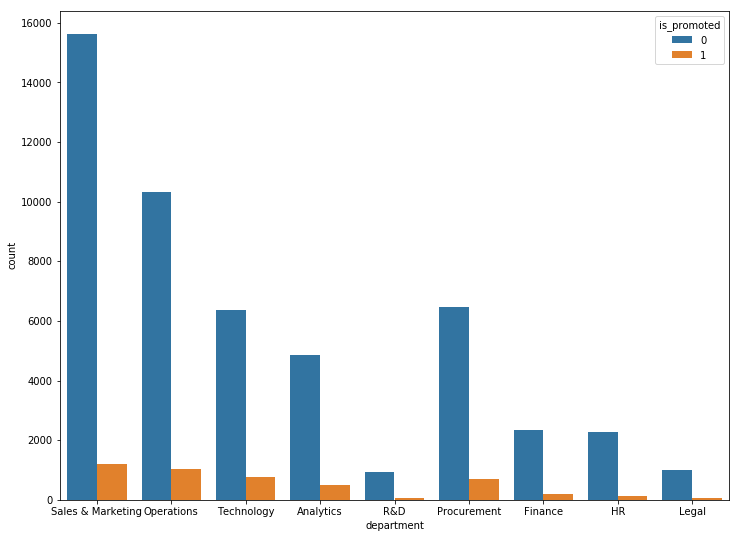

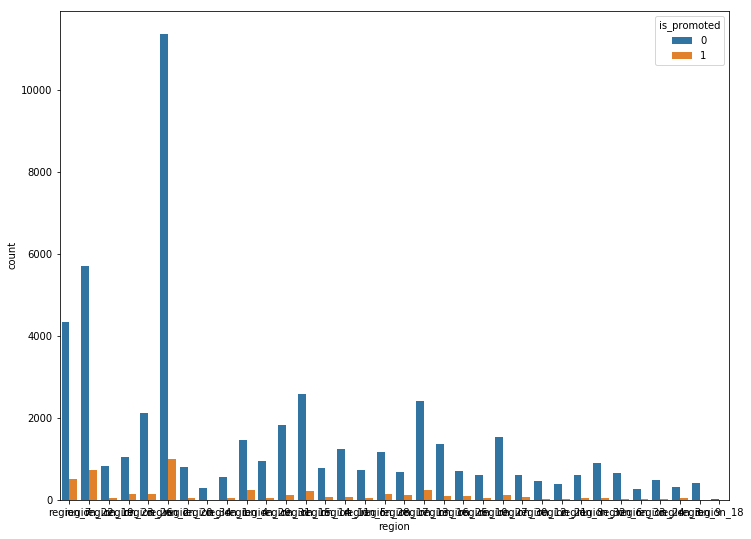

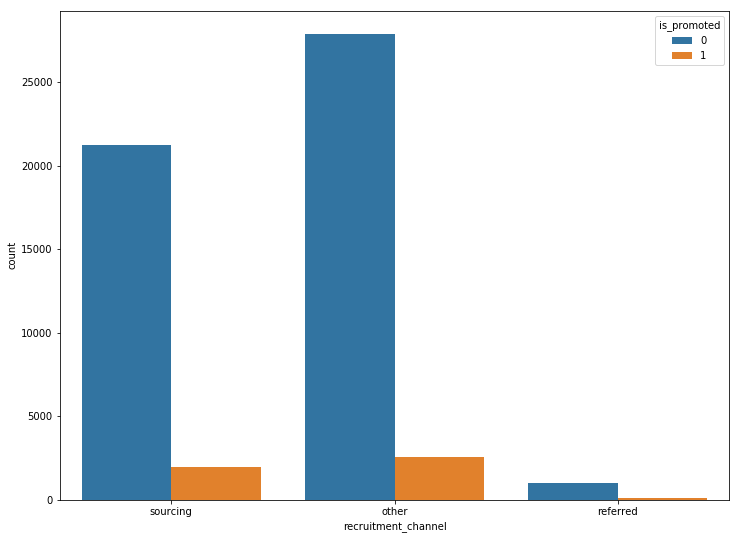

In [184]:
#EDA - 6 Bi-variate analysis on nominal variables
for i in df_nominal_col:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    sns.countplot(x=i, data=df_train, hue='is_promoted')
    plt.show()

In [185]:
df[df_binary_col] = df[df_binary_col].pipe(LabelEncoding_Cat)
print ('dataset:', df.shape)

dataset: (78298, 14)


In [187]:
# ####### Chi-SQ test on Categorical variables
# def chisq_of_df_cols(df, c1, c2):
#     groupsizes = df.groupby([c1, c2]).size()
#     ctsum = groupsizes.unstack(c1)
#     # fillna(0) is necessary to remove any NAs which will cause exceptions
#     return(chi2_contingency(ctsum.fillna(0)))

# def ChiSqPostHoc(df,col):
#     dummies = pd.get_dummies(df[col])
#     for series in dummies:
#         nl = "\n"
#         crosstab = pd.crosstab(dummies[series], df['is_promoted'])
#         print (crosstab, nl)
#         chi2, p, dof, expected = chi2_contingency(crosstab.fillna(0))
#         print ('Chi2 value:', chi2, nl, 'p-value:', p, nl, 'dof:', dof,nl)

In [188]:
# tr_df.groupby(['education_coded', 'is_promoted']).size()

In [189]:
# tri=df_train.shape[0]
# tr_df=df.iloc[:tri,:].copy()

# print ('CHI-SQ test:\n', chisq_of_df_cols(tr_df, 'education_coded', 'is_promoted'))

# #Post hoc Chi-Sq testing - department
# print ('Post-hoc test:\n', ChiSqPostHoc(tr_df,'education_coded'))

# del tr_df
# gc.collect()

In [311]:
# colsToInclude = ['department_Analytics','department_HR','department_Legal','department_Procurement',
#                  'department_Technology','department_Sales & Marketing','recruitment_channel_referred',
#                  'region_region_11','region_region_17','region_region_19','region_region_20','region_region_21',
#                  'region_region_22','region_region_23','region_region_24','region_region_25','region_region_26',
#                  'region_region_28','region_region_29','region_region_31','region_region_32','region_region_33',
#                  'region_region_34','region_region_4','region_region_5','region_region_6','region_region_7','region_region_9']

In [190]:
# def selected_dummy_cols(df,dummy_cat_cols,colsToInclude=None):
#     dummies = create_dummy_set(dummy_cat_cols,df[dummy_cat_cols])
# #     dummies = dummies[colsToInclude]
#     df_n = pd.concat([df, dummies], axis=1, join_axes=[df.index])
#     df_n.drop(dummy_cat_cols,axis=1,inplace=True)
#     return df_n

In [191]:
# df = selected_dummy_cols(df,df_nominal_col)
# # df = selected_dummy_cols(df,df_nominal_col,colsToInclude)
# df.shape

In [192]:
# region_col = ['region_region_11','region_region_17','region_region_19','region_region_20','region_region_21',
#               'region_region_22','region_region_23','region_region_24','region_region_25','region_region_26',
#               'region_region_28','region_region_29','region_region_31','region_region_32','region_region_33',
#               'region_region_34','region_region_4','region_region_5','region_region_6','region_region_7','region_region_9']

In [193]:
# reg_cols = [col for col in df.columns if 'region' in col if col not in region_col]
# df.drop(reg_cols, axis=1, inplace=True)

In [194]:
# # Threshold for removing correlated variables
# threshold = 0.9999999999999

# # Absolute value correlation matrix
# corr_matrix = tr_df.corr().abs()
# # corr_matrix.head()

# # Upper triangle of correlations
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# # upper.head()

In [195]:
# # # Select columns with correlations above threshold
# to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# print('There are %d columns to remove.' % (len(to_drop)))

In [196]:
# def corr_check(col):
#     return upper[col].loc[upper[col] > 0.1].to_frame()
# corr_check('is_promoted')

In [25]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [129]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators = 500, random_state=2323)
clf3 = GaussianNB()
clf4 = KNeighborsClassifier(n_neighbors = 1000)
clf5 = AdaBoostClassifier()

In [133]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Bayesian Opt
def kfold_logistic(df, num_folds, PCA_feats = None, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['is_promoted'].notnull()]
#     train_df = train_df[:10000]
    test_df = df[df['is_promoted'].isnull()].copy()
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['is_promoted','employee_id','index']]
    

#     eclf = VotingClassifier(estimators=[('lr', clf1), ('gnb', clf3), ('knn', clf4),
#                                     ('ada', clf5)],
# #                                     weights=[1,1,1,1], 
#                                     voting='hard')
#     eclf = eclf.fit(X, y)
#     eclf_preds = np.zeros(df.shape[0])
#     eclf_preds = eclf.predict(X)[:,1]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['is_promoted'])):
     
        evals_result = {}
        thresh = 0.253555
#         thresh = 0.31
        
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['is_promoted'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['is_promoted'].iloc[valid_idx]
        
        clf = clf2
        clf.fit(train_x, train_y)
        
        oof_preds[valid_idx] = clf.predict_proba(train_df[feats].iloc[valid_idx])[:,1]
        sub_preds += clf.predict_proba(test_df[feats])[:,1] / folds.n_splits
        
        print('Fold %2d F-1 : %.6f' % (n_fold + 1, f1_score(train_df['is_promoted'].iloc[valid_idx],(oof_preds[valid_idx] > thresh ).astype(int))))
        del train_x, train_y, valid_x, valid_y
        gc.collect() 
    
    np.savetxt(dir+"log_oof_preds.csv", oof_preds, delimiter=",") 

    print('Full F-1 score %.6f' % f1_score(train_df['is_promoted'], (oof_preds > thresh).astype(int)))
    # Write submission file and plot feature importance
    if not debug:
        Submission=pd.read_csv(dir+"sample_submission.csv")
        Submission['is_promoted']=(sub_preds > thresh).astype(int).copy()
        Submission.to_csv(dir+"submission_log_Clf.csv", index= False)
    return feature_importance_df

In [134]:
#run logistic model
feat_importance = kfold_logistic(df, num_folds = 4, stratified= False)

Starting LightGBM. Train shape: (54808, 57), test shape: (23490, 57)
Fold  1 F-1 : 0.479359
Fold  2 F-1 : 0.460963
Fold  3 F-1 : 0.466258
Fold  4 F-1 : 0.472696
Full F-1 score 0.469872


In [132]:
#run RF model
feat_importance = kfold_logistic(df, num_folds = 4, stratified= False)

Starting LightGBM. Train shape: (54808, 57), test shape: (23490, 57)
Fold  1 F-1 : 0.491803
Fold  2 F-1 : 0.479532
Fold  3 F-1 : 0.485810
Fold  4 F-1 : 0.477273
Full F-1 score 0.483715


In [391]:
print(opt_params)

{'num_leaves': 20.0, 'feature_fraction': 0.99, 'bagging_fraction': 0.8, 'max_depth': 9.0, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'min_split_gain': 0.01, 'scale_pos_weight': 2.0, 'min_child_weight': 43.31164853986652}


In [27]:
from numpy import median

In [144]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Bayesian Opt
def kfold_lightgbm(df, num_folds, PCA_feats = None, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['is_promoted'].notnull()]
#     train_df = train_df[:10000]
    test_df = df[df['is_promoted'].isnull()].copy()
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['is_promoted','employee_id','index']]
#     feats = ['previous_year_rating','KPIs_met >80%','awards_won?','avg_training_score']
    
    Dparam = {'objective' : 'binary','boosting_type': 'gbdt',
#           'weight_column': "name:LOAN_WEIGHTS",
          'random_state':23,'nthread' : 4,
#               'metric' : 'auc',
          'shrinkage_rate':0.01,'max_depth':9,'min_child_weight':43.31164853986652,
          'bagging_fraction':0.8,'feature_fraction':0.99,'bagging_freq' : 1,'scale_pos_weight': 2.0,
          'lambda_l1':0,'lambda_l2':0,'num_leaves':20,'min_gain_to_split':0.01} 

#     Dparam = {'objective' : 'binary',
#           'boosting_type': 'gbdt',
# #           'weight_column': "name:LOAN_WEIGHTS",
#           'random_state':23,
#           'metric' : 'auc',
#           'nthread' : 4,
#           'shrinkage_rate':0.01,
#           'max_depth':8,
#           'min_child_weight':47.4521998,
#           'bagging_fraction':1.0,
#           'feature_fraction':0.95,
#           'scale_pos_weight':2.398597,     
#           'bagging_freq' : 1,
#           'lambda_l1':4.99842044,
#           'lambda_l2':1.60494325,
#           'num_leaves':36,
#           'min_gain_to_split':0.0753679496}
    
    def lgb_f1_score(y_hat, dtrain):
        y_true = dtrain.get_label()
#         y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
        y_hat = (y_hat > 0.44).astype(int)
        return 'f1', f1_score(y_true, y_hat), True
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['is_promoted'])):
        evals_result = {}
        thresh = 0.44
        dtrain = lgb.Dataset(train_df[feats].iloc[train_idx], train_df['is_promoted'].iloc[train_idx])
        dval = lgb.Dataset(train_df[feats].iloc[valid_idx], train_df['is_promoted'].iloc[valid_idx])
 
        m_gbm=lgb.train(params=Dparam,train_set=dtrain,num_boost_round=10000,verbose_eval=1000,early_stopping_rounds=200,
                        feval = lgb_f1_score, valid_sets=[dtrain,dval],valid_names=['train','valid'], evals_result=evals_result)
        
        lgb.plot_metric(evals_result, metric='f1')
        
        oof_preds[valid_idx] = m_gbm.predict(train_df[feats].iloc[valid_idx], num_iteration=m_gbm.best_iteration)
        sub_preds += m_gbm.predict(test_df[feats] , num_iteration=m_gbm.best_iteration) / folds.n_splits
        
        print('Fold %2d F-1 : %.6f' % (n_fold + 1, f1_score(train_df['is_promoted'].iloc[valid_idx],(oof_preds[valid_idx] > thresh).astype(int))))
        del dtrain,dval
        gc.collect() 
    
    np.savetxt(dir+"lgb_oof_preds.csv", oof_preds, delimiter=",") 

    print('Full F-1 score %.6f' % f1_score(train_df['is_promoted'], (oof_preds > thresh).astype(int)))
    # Write submission file and plot feature importance
    if not debug:
        Submission=pd.read_csv(dir+"sample_submission.csv")
        Submission['is_promoted']=sub_preds.copy()
#         Submission['is_promoted']=(sub_preds > thresh).astype(int).copy()
        Submission.to_csv(dir+"submission_LGB_Clf.csv", index= False)
    return feature_importance_df, sub_preds

Starting LightGBM. Train shape: (54808, 57), test shape: (23490, 57)
Training until validation scores don't improve for 200 rounds.
[1000]	train's f1: 0.541185	valid's f1: 0.539267
Early stopping, best iteration is:
[1274]	train's f1: 0.551541	valid's f1: 0.544711
Fold  1 F-1 : 0.544711
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[598]	train's f1: 0.521265	valid's f1: 0.507172
Fold  2 F-1 : 0.507172
Training until validation scores don't improve for 200 rounds.
[1000]	train's f1: 0.546046	valid's f1: 0.514884
Early stopping, best iteration is:
[1439]	train's f1: 0.559426	valid's f1: 0.526824
Fold  3 F-1 : 0.526824
Training until validation scores don't improve for 200 rounds.
[1000]	train's f1: 0.55247	valid's f1: 0.503304
Early stopping, best iteration is:
[1434]	train's f1: 0.566427	valid's f1: 0.511382
Fold  4 F-1 : 0.511382
Full F-1 score 0.523011


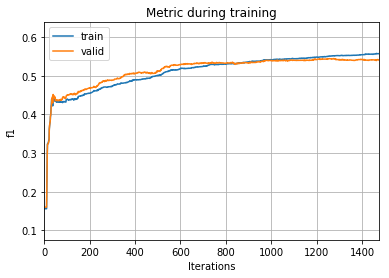

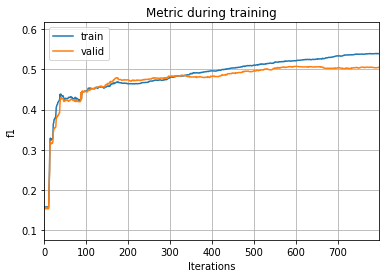

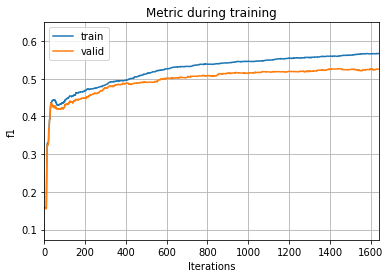

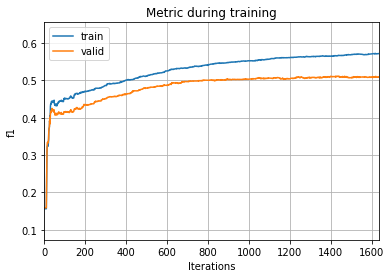

In [146]:
#run LightGBM model
feat_importance, sub_preds = kfold_lightgbm(df, num_folds = 4, stratified= False)

In [398]:
from numpy import median
median(sub_preds)

0.022743484767878505

In [197]:
# display_importances(feat_importance)
Submission=pd.read_csv(dir+"sample_submission.csv")
# Submission['is_promoted']=sub_preds.copy()
Submission['is_promoted']=(sub_preds > 0.4).astype(int).copy()
Submission.to_csv(dir+"submission_LGB_Clf.csv", index= False)

In [149]:
import glob
import pandas as pd

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import numpy as np

dir = '../Documents/JK/AV_WNS/'

In [150]:
# USING Voting METHOD
data = {}

for path in glob.glob("../Documents/JK/AV_WNS/Oof_files/*.csv", recursive=True):
    data[path[65:-4]] = pd.read_csv(path, header=None)

oof_preds = pd.DataFrame(columns=data.keys())

id_tgt = pd.read_csv('../Documents/JK/AV_WNS/Oof_files/ID_TGT/id_target.csv', index_col=0).reset_index(drop=True)
df = id_tgt.join(oof_preds)

for key in data.keys():
    df[key] = data[key]

df.head()

,employee_id,is_promoted,
0,65438,0,0.184
1,65141,0,0.008
2,7513,0,0.000
3,2542,0,0.002
4,48945,0,0.026


In [ ]:
data_sub = {}

for path in glob.glob("../Documents/JK/AV_WNS/Test/*.csv", recursive=True):
    data_sub[path[65:-4]] = pd.read_csv(path, header=0)

sub_preds = pd.DataFrame(columns=data_sub.keys())

id_test = pd.read_csv('../Documents/JK/AV_WNS/Test/sample/sample_submission.csv')
id_test.drop('is_promoted',axis=1,inplace=True)
df_test = id_test.join(sub_preds)

for key in data_sub.keys():
    df_test[key] = data_sub[key].TARGET
    
df_test.head()

In [ ]:
df_test.corr()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators = 500, random_state=1, warm_start = True)
clf3 = GaussianNB()
clf4 = KNeighborsClassifier(n_neighbors = 1000)
clf5 = AdaBoostClassifier()

In [ ]:
X = df.drop(['is_promoted','employee_id'], axis=1)
y = df['is_promoted']

In [ ]:
eclf = VotingClassifier(estimators=[('lr', clf1), ('gnb', clf3), ('knn', clf4),
                                    ('ada', clf5)],
#                                     weights=[1,1,1,1], 
                                    voting='soft')
eclf = eclf.fit(X, y)
eclf_preds = np.zeros(df.shape[0])
eclf_preds = eclf.predict_proba(X)[:,1]
# eclf_tfm = eclf.transform(X)

print('Full F-1 score %.6f' % f1_score(y, eclf_preds))

In [ ]:
models = [clf1, clf3, clf4, clf5]

from sklearn.model_selection import cross_val_score

for model in models:
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(str(model)[:5], scores.mean(), scores.std())

In [ ]:
X_test = df_test.drop(['employee_id'], axis=1)
eclf_sub_preds = np.zeros(df_test.shape[0])
eclf_sub_preds = eclf.predict_proba(X_test)[:,1]

In [ ]:
Submission=pd.read_csv(dir+"sample_submission.csv")
Submission['is_promoted']=eclf_sub_preds.copy()
Submission.to_csv(dir+"submission_Voting.csv", index= False)
Submission.head()

In [387]:
from bayes_opt import BayesianOptimization

In [388]:
def bayes_parameter_opt_lgb(df, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.1, output_process=False):
    # prepare data
    df_train = df[df['is_promoted'].notnull()]
#     df_train = df_train[:10000]
    # Target
    y = df_train['is_promoted'].copy()
    feats = [f for f in df_train.columns if f not in ['is_promoted','employee_id','index']]
    df_train = df_train[feats]
    train_data = lgb.Dataset(data=df_train, label = y, free_raw_data=False)
    
    def lgb_f1_score(y_hat, train_data):
        y_true = train_data.get_label()
        y_hat = (y_hat > 0.5).astype(int)
        return 'f1', f1_score(y_true, y_hat), True
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, 
                 min_split_gain, min_child_weight, scale_pos_weight):
        params = {'application':'binary','num_iterations': n_estimators,'learning_rate':learning_rate, 
                  'early_stopping_round':150,'bagging_freq':1, 'metric':'auc','n_jobs':4}
        
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, 
                           verbose_eval = 500, feval = lgb_f1_score)
        return max(cv_result['f1-mean'])
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (20, 50),
                                            'feature_fraction': (0.1, 0.99),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (4, 9),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.01, 0.1),
                                            'scale_pos_weight': (2, 10),
                                            'min_child_weight': (20, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv(dir+"bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']

In [390]:
opt_params = bayes_parameter_opt_lgb(df, init_round=15, opt_round=25, n_folds=5, random_seed=123456, n_estimators=10000, learning_rate=0.02)
print(opt_params)

Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_split_gain |   num_leaves |   scale_pos_weight | 
[500]	cv_agg's auc: 0.865941 + 0.00216441	cv_agg's f1: 0.223789 + 0.0122555
[1000]	cv_agg's auc: 0.890239 + 0.00208593	cv_agg's f1: 0.308257 + 0.0175159
[1500]	cv_agg's auc: 0.898822 + 0.00288486	cv_agg's f1: 0.367125 + 0.0147806
[2000]	cv_agg's auc: 0.902193 + 0.00320605	cv_agg's f1: 0.412642 + 0.0110526
[2500]	cv_agg's auc: 0.903843 + 0.00319246	cv_agg's f1: 0.438399 + 0.0107371
[3000]	cv_agg's auc: 0.904879 + 0.00319043	cv_agg's f1: 0.451635 + 0.00981995
[3500]	cv_agg's auc: 0.905521 + 0.00333668	cv_agg's f1: 0.46143 + 0.00993087
[4000]	cv_agg's auc: 0.905876 + 0.00325395	cv_agg's f1: 0.466462 

[1000]	cv_agg's auc: 0.904633 + 0.00193778	cv_agg's f1: 0.485351 + 0.0134957
[1500]	cv_agg's auc: 0.905286 + 0.00234537	cv_agg's f1: 0.492155 + 0.0132483
[2000]	cv_agg's auc: 0.90555 + 0.00249495	cv_agg's f1: 0.494772 + 0.0116823
   16 | 03m25s |    0.49562 |             0.8000 |             0.9900 |      5.0000 |      0.0000 |      9.0000 |            50.0000 |           0.0100 |      20.0000 |             2.0000 | 
[500]	cv_agg's auc: 0.905113 + 0.00150894	cv_agg's f1: 0.483738 + 0.0138066
[1000]	cv_agg's auc: 0.906701 + 0.00204914	cv_agg's f1: 0.493953 + 0.0101792
   17 | 02m19s |    0.49466 |             0.8000 |             0.9900 |      5.0000 |      0.0000 |      9.0000 |            20.0000 |           0.0100 |      35.0000 |             2.0000 | 
[500]	cv_agg's auc: 0.902283 + 0.00161285	cv_agg's f1: 0.468038 + 0.0136585
[1000]	cv_agg's auc: 0.904415 + 0.00186714	cv_agg's f1: 0.484319 + 0.0119663
[1500]	cv_agg's auc: 0.905069 + 0.00226376	cv_agg's f1: 0.491432 + 0.0134832
   18

[1000]	cv_agg's auc: 0.906664 + 0.00186857	cv_agg's f1: 0.487092 + 0.0103598
[1500]	cv_agg's auc: 0.907695 + 0.0018731	cv_agg's f1: 0.493368 + 0.0138329
[2000]	cv_agg's auc: 0.908203 + 0.0019613	cv_agg's f1: 0.496228 + 0.0123009
[2500]	cv_agg's auc: 0.908359 + 0.00202557	cv_agg's f1: 0.497656 + 0.0129969
   34 | 02m22s |    0.49881 |             0.8000 |             0.9900 |      0.0000 |      0.0000 |      4.0000 |            20.0000 |           0.0100 |      20.0000 |            10.0000 | 
[500]	cv_agg's auc: 0.89662 + 0.0026462	cv_agg's f1: 0.431517 + 0.00959819
[1000]	cv_agg's auc: 0.902862 + 0.00220193	cv_agg's f1: 0.476729 + 0.01334
[1500]	cv_agg's auc: 0.904949 + 0.00239592	cv_agg's f1: 0.485198 + 0.0126479
[2000]	cv_agg's auc: 0.905929 + 0.00242308	cv_agg's f1: 0.490357 + 0.013782
[2500]	cv_agg's auc: 0.906391 + 0.00240585	cv_agg's f1: 0.49299 + 0.0124122
   35 | 02m28s |    0.49322 |             0.8000 |             0.9900 |      5.0000 |      0.0000 |      4.0000 |           